## Soilmoisture analysis for Mozambique

- The aim of this notebook is to show and teach a possible workflow for analyzing and validating soil moisture data in Mozambique retrieved from ground measurements and ASCAT satellite data

- The given in-situ data is provided by [Zentracloud](docs.zentracloud.com/l/en/category/wcao1f5pt0-zentra-api) and the ASCAT satellite data is provided by the [TU Vienna Remote Sensing Research Group](https://www.tuwien.at/mg/geo/rs)

- We will focus on the areas Buzi, Chokwé, Mabalane, Mabote and Muanza in Mozambique

- The workflow is already completed. However you’re encouraged to explore the code and try out your own modifications


### Workflow

1. Mapping the areas of interest

2. Visualizing the data

3. Data analysis and manipulation 




_____________________________

- At first we need to import necessary packages.


In [2]:
from datetime import datetime
import numpy as np
import xarray as xr
import geopandas as gpd
import osmnx as ox
import os
import folium
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import box



### 1. Mapping the areas of interest

- When working with Earth observation data, we often need a bounding box, which is a rectangular shape on the map, to specify the observed area

- The code below retrieves the bouning boxes for each area defined in area_names from OpenStreetMap

In [17]:
area_names =["Buzi","Chokwé","Mabalane","Mabote","Muanza"]


def bbox (area_names):


    area_dict = dict()

    for area_name in area_names:

        # Get GeoDataFrame from OpenStreetMap
        gdf = ox.geocode_to_gdf(area_name)
        # Get bounding box [minx, miny, maxx, maxy]
        bbox = gdf.total_bounds  

        # To get a proper bounding box for processing later on in the shape of [min_lon, max_lon, min_lat, max_lat]
        bbox= [float(bbox[0]), float(bbox[2]), float(bbox[1]), float(bbox[3])] 

        area_dict[area_name] = bbox
    
    return(area_dict)


area_dict = bbox(area_names)

print(area_dict)

{'Buzi': [33.8931254, 34.8127126, -20.5695588, -19.582687], 'Chokwé': [32.5596257, 33.5225846, -24.8651389, -24.1120627], 'Mabalane': [32.2377105, 33.2483723, -24.1967515, -22.9668694], 'Mabote': [33.1611587, 34.6342067, -22.9057726, -21.3023939], 'Muanza': [34.4736235, 35.6973266, -19.5313462, -18.6416478]}


- To visualize the bounding boxes from above on a map we use a package called cartopy

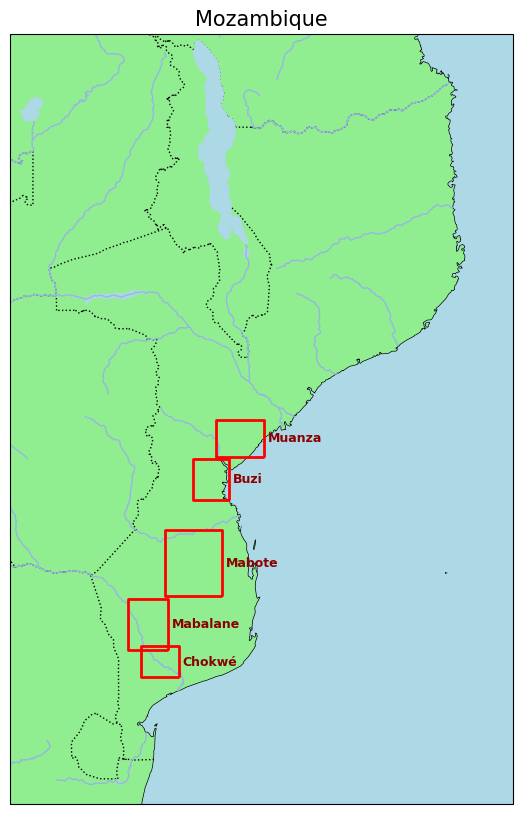

In [ ]:
def map_cartopy(obs_area, area_dict):

    # Get bounding box for the area containing all the other bboxes from OpenStreetMap
    gdf = ox.geocode_to_gdf(obs_area)
    bbox = gdf.total_bounds  # [minx, miny, maxx, maxy]
    bbox = [float(bbox[0]), float(bbox[2]), float(bbox[1]), float(bbox[3])]  # [min_lon, max_lon, min_lat, max_lat]

    # Calculate center for map projection
    center_lon = (bbox[0] + bbox[1]) / 2
    center_lat = (bbox[2] + bbox[3]) / 2

    # Create plot
    fig, ax = plt.subplots(figsize=(10, 10),
                           subplot_kw={'projection': ccrs.PlateCarree()})
    
    # Set extent (with buffer)
    buffer_deg = 1.0
    ax.set_extent([bbox[0] - buffer_deg, bbox[1] + buffer_deg,
                   bbox[2] - buffer_deg, bbox[3] + buffer_deg],
                  crs=ccrs.PlateCarree())

    # Add map features
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgreen')
    ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
    ax.add_feature(cfeature.LAKES, edgecolor='lightblue', facecolor='lightblue')
    ax.add_feature(cfeature.RIVERS)

    # Plot bounding boxes and labels
    for ent in area_dict:
        bb = area_dict[ent]  # [min_lon, max_lon, min_lat, max_lat]
        rect = box(bb[0], bb[2], bb[1], bb[3])  # rectangle shape in cartopy: (minx, miny, maxx, maxy)
        gdf_rect = gpd.GeoDataFrame(index=[0], geometry=[rect], crs='EPSG:4326')
        gdf_rect.boundary.plot(ax=ax, edgecolor='red', linewidth=2)

        # Label to the right of the bounding box
        label_x = bb[1] + 0.1  # Slightly to the right of max_lon
        label_y = (bb[2] + bb[3]) / 2  # Vertically centered
        ax.text(label_x, label_y, ent,
                transform=ccrs.PlateCarree(),
                ha='left', va='center', fontsize=9, color='darkred', weight='bold')

    ax.set_title(f"{obs_area}", fontsize=15)
    plt.show()

# Example use (make sure you have area_dict defined):
map_cartopy("Mozambique", area_dict)


### 2. Visualizing the data


- Now, let us take a first look at the data 

- The dataset obs_data contains both the ASCAT and the in-situ soil moisture data

- It might be surprising to find so many NaN values in the ASCAT column, but this is due to the setup of the satellite and its measuring device 

- Unlike devices that capture spatially and temporally continuous data, ASCAT only measures specific points on earth at certain times

- Therefore we only have values for specific timestamps in ASCAT column, compared to the continuous looking data from the in-situ measurements

In [ ]:
obs_data = pd.read_csv("~/drysat_jupyterhub/ascat_insitu_merge/obs_data.csv")

print(obs_data.head(15), "\n")

               datetime  in-situ m³/m³    ascat %  location
0   2023-12-31 23:00:00       0.090967        NaN  Mabalane
1   2024-01-01 00:00:00       0.090676        NaN  Mabalane
2   2024-01-01 01:00:00       0.090313        NaN  Mabalane
3   2024-01-01 02:00:00       0.089985        NaN  Mabalane
4   2024-01-01 03:00:00       0.089548        NaN  Mabalane
5   2024-01-01 04:00:00       0.089110        NaN  Mabalane
6   2024-01-01 05:00:00       0.088927        NaN  Mabalane
7   2024-01-01 06:00:00       0.088780  36.879580  Mabalane
8   2024-01-01 07:00:00       0.088927  41.127928  Mabalane
9   2024-01-01 08:00:00       0.089365        NaN  Mabalane
10  2024-01-01 09:00:00       0.089840        NaN  Mabalane
11  2024-01-01 10:00:00       0.090095        NaN  Mabalane
12  2024-01-01 11:00:00       0.089730        NaN  Mabalane
13  2024-01-01 12:00:00       0.088963        NaN  Mabalane
14  2024-01-01 13:00:00       0.088267        NaN  Mabalane 



In [ ]:
import pandas as pd
from pandas.api.types import CategoricalDtype

long_df = pd.melt(
    obs_data,
    id_vars=["datetime", "location"],
    value_vars=["in-situ m³/m³", "ascat %"],
    var_name="source",
    value_name="soil moisture value"
).dropna(subset=["soil moisture value"])

source_order = CategoricalDtype(categories=["in-situ m³/m³", "ascat %"], ordered=True)
long_df["source"] = long_df["source"].astype(source_order)

# Sort so for each location, all in-situ first sorted by datetime, then all ascat sorted by datetime
long_df = long_df.sort_values(by=["location", "source", "datetime"], ascending=[True, True, True])

long_df = long_df[["datetime", "location", "soil moisture value", "source"]]

long_df.to_csv("~/drysat_jupyterhub/ascat_insitu_merge/obs_data_long.csv", index=False)


- When working with tabular datasets such as Excel files, the well-known pandas library is extremely useful

- For example, we might want to focus specifically on the data for Buzi

In [20]:
obs_data[obs_data["location"] == "Buzi"]

,datetime,in-situ m³/m³,ascat %,location
17522,2023-12-31 23:00:00,0.224695,NaN,Buzi
17523,2023-12-31 23:15:00,0.224578,NaN,Buzi
17524,2023-12-31 23:30:00,0.224508,NaN,Buzi
17525,2023-12-31 23:45:00,0.224462,NaN,Buzi
17526,2024-01-01 00:00:00,0.224368,NaN,Buzi
...,...,...,...,...
34604,2024-12-30 19:00:00,0.097370,NaN,Buzi
34605,2024-12-30 20:00:00,0.097300,NaN,Buzi
34606,2024-12-30 21:00:00,0.097194,NaN,Buzi
34607,2024-12-30 22:00:00,0.097158,NaN,Buzi


- Visualizing the data can help to get a better intuition for further analysis and manipulation 

- Thus we plot the ascat and in-situ data for each observed area Buzi, Chokwé, Mabalane, Mabote, Muanza 

- As explained earlier, the in-situ data appears quite continuous, while the ASCAT data has only a few values scattered along the timeline

- Therefore in order to compute two properly looking line graphs for each dataset we have to [interpolate](https://www.geeksforgeeks.org/pandas-dataframe-interpolate/) the missing ascat data

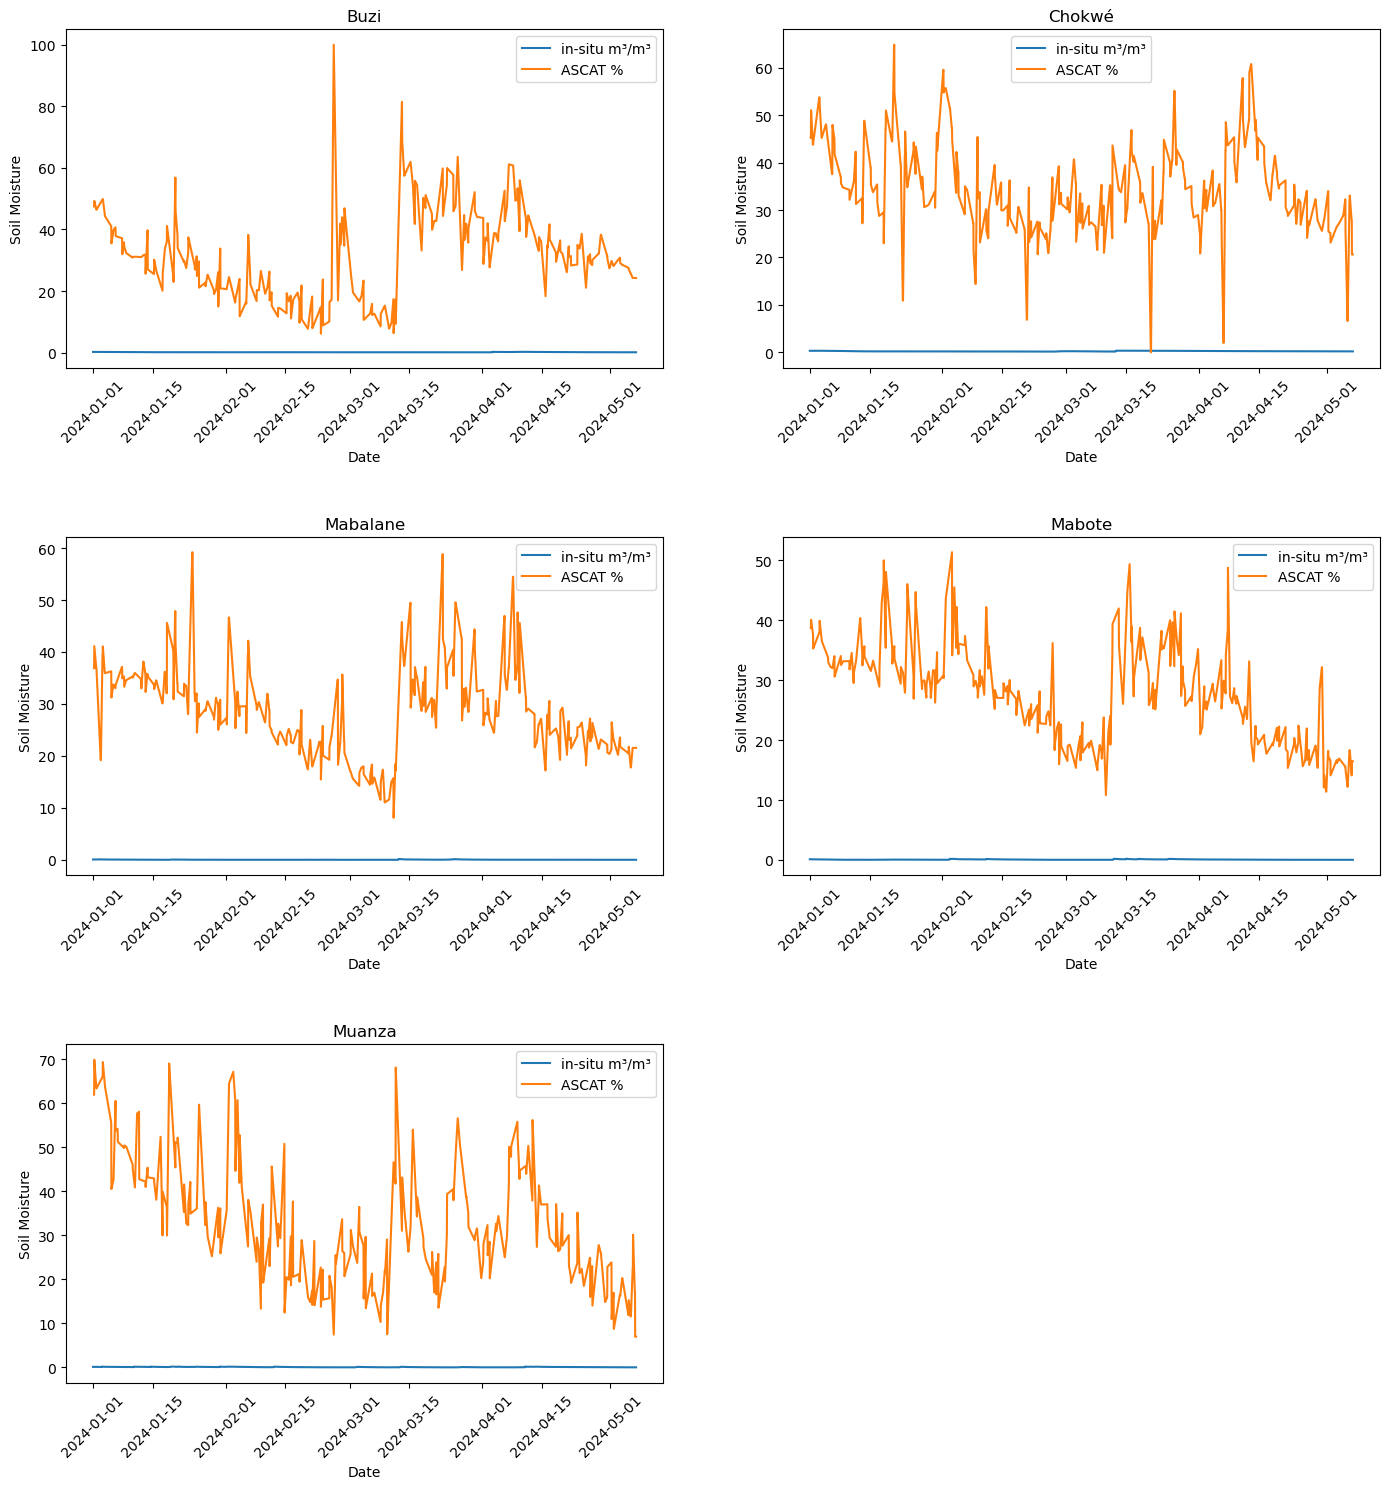

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import math

# Function to plot the line graph for multiple locations in one row
def plot_multiple_locations(data, location_names, start_date, end_date):
    data['datetime'] = pd.to_datetime(data['datetime'], errors="coerce")

    num_locations = len(location_names)
    cols = 2  # Number of plots per row
    rows = math.ceil(num_locations / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(14, 5 * rows), squeeze=False)

    for i, location_name in enumerate(location_names):
        row, col = divmod(i, cols)
        ax = axes[row][col]

        # Filter and process data
        location_data = data[data['location'] == location_name].copy()
        location_data = location_data[
            (location_data['datetime'] >= pd.to_datetime(start_date)) &
            (location_data['datetime'] <= pd.to_datetime(end_date))
        ]
        location_data['ascat %'] = location_data['ascat %'].bfill(limit=1)
        location_data = location_data.set_index("datetime")
        location_data['ascat interpolated'] = location_data['ascat %'].interpolate(method='time')

        # Plotting
        ax.plot(location_data.index, location_data['in-situ m³/m³'], label='in-situ m³/m³', color='tab:blue')
        ax.plot(location_data.index, location_data['ascat interpolated'], label='ASCAT %', color='tab:orange')
        ax.set_title(f'{location_name}')
        ax.set_xlabel('Date')
        ax.set_ylabel('Soil Moisture')
        ax.legend()
        ax.tick_params(axis='x', rotation=45)

    # Hide unused subplots if number of locations is odd
    for j in range(i + 1, rows * cols):
        row, col = divmod(j, cols)
        fig.delaxes(axes[row][col])

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.2, hspace=0.5) 
    plt.show()

# Example usage:
start_date = '2024-01-01 00:00:00'
end_date = '2024-05-07 00:00:00'
plot_multiple_locations(obs_data, area_names, start_date, end_date)


### 3. Data analysis and manipulation 

- In the step visualization two key insights stand out 

- First the in-situ and ASCAT data are presented in different units m³/m³ and percentage %

- Second the ASCAT line graph shows noticeable fluctuations over time, whereas the in-situ line graph appears relatively stable and low 

- The difference of the units and the plots is actually a consequence of the different measurement techniques used in-situ and by ASCAT

- This is a key point to consider when performing further analysis and manipulation

- In order to understand how we could normalize the in-situ data and make it comparable with the ASCAT data we have to take a closer look at the soil, its components, certain physical quantities and formulas that are important for further calculations

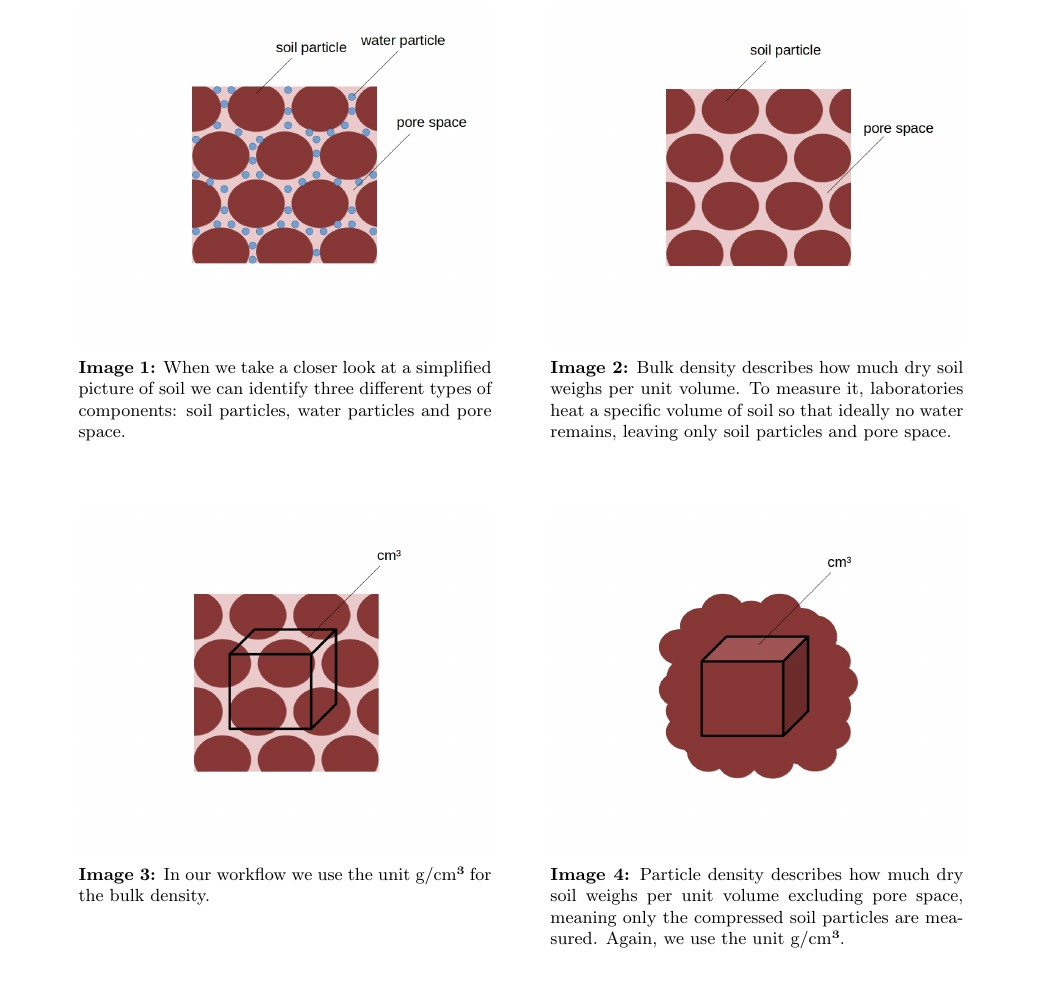

In [ ]:
from IPython.display import Image, display
display(Image(filename='images/soil_final.jpg', width= 1100, height= 1100))

- The images shown above should familiarize us with certain geophysical quantities necessary for further calculations

- Now let us examine the formulas needed to normalize the in-situ data 

- Formula 1 involves the bulk density and particle density and calculates the porosity

- We can obtain the specific bulk density for our observation areas in Mozambique from [SoilGrids](https://soilgrids.org/)

- The particle density is typically averaged at about 2.65 g/cm³ [(see this study)](https://www.sciencedirect.com/science/article/pii/S0016706105000431)

$$
\text{Porosity} = \left(1 - \frac{\rho_{\text{bulk}}}{\rho_{\text{particle}}} \right) \times 100
$$

$$
\begin{array}{c}
\text{formula 1: Porosity}
\end{array}
$$

$$
\begin{aligned}
\text{Porosity} &\quad \text{: Total pore space in the soil – percentage of the total soil volume that is pore space (in \%)} \\
\rho_{\text{bulk}} &\quad \text{: Bulk density (in g/cm³)} \\
\rho_{\text{particle}} &\quad \text{: Particle density (in g/cm³)} \\
\end{aligned}
$$


In [10]:
import pandas as pd

area_names =["Buzi","Chokwé","Mabalane","Mabote","Muanza"]


bulk_dens = [1.25, 1.4, 1.4, 1.35, 1.25] #bulk density for "Buzi", "Chokwé", "Mabalane", "Mabote", "Muanza", given in g/cm³
poros = []

for i in bulk_dens:

    p = 1 -(i/2.65)
    poros.append(p) 

poros = pd.DataFrame({"location": area_names, "porosity %": poros})

poros

,location,porosity %
0,Buzi,0.528302
1,Chokwé,0.471698
2,Mabalane,0.471698
3,Mabote,0.490566
4,Muanza,0.528302


- Next we want to combine the porosity dataframe with the obs_data dataframe 

- obs_data is not too little therefore we have to compute in a smart, fast and memory efficient way

In [11]:
import sys

print("The length of the dataframe is", len(obs_data), "rows", "\n")
print("The size of the whole dataframe is about", sys.getsizeof(obs_data)/(10**6), "MB")

obs_data.head(10)

The length of the dataframe is 68784 rows 

The size of the whole dataframe is about 9.684664 MB


,datetime,in-situ m³/m³,ascat %,location
0,2023-12-31 23:00:00,0.090967,NaN,Mabalane
1,2024-01-01 00:00:00,0.090676,NaN,Mabalane
2,2024-01-01 01:00:00,0.090313,NaN,Mabalane
3,2024-01-01 02:00:00,0.089985,NaN,Mabalane
4,2024-01-01 03:00:00,0.089548,NaN,Mabalane
5,2024-01-01 04:00:00,0.089110,NaN,Mabalane
6,2024-01-01 05:00:00,0.088927,NaN,Mabalane
7,2024-01-01 06:00:00,0.088780,36.879580,Mabalane
8,2024-01-01 07:00:00,0.088927,41.127928,Mabalane
9,2024-01-01 08:00:00,0.089365,NaN,Mabalane


- Rather than writing code that naively iterates over each of the 68,784 rows, we can take advantage of a powerful feature of the pandas library: [optimized join operations](https://www.geeksforgeeks.org/different-types-of-joins-in-pandas/)

- The basic principle of a left join is to combine each row of the left dataframe with each row of right datframe if a certain condition is fullfilled

- If the condition is not fullfilled the left join keeps the row of the left dataframe and fills the rest of the row with NaNs

- In our case we want to make a left join with dataframe poros and dataframe obs_data based on the condition "location"


In [12]:
merged_df = obs_data.merge(poros, how="left", on="location")

merged_df


,datetime,in-situ m³/m³,ascat %,location,porosity %
0,2023-12-31 23:00:00,0.090967,NaN,Mabalane,0.471698
1,2024-01-01 00:00:00,0.090676,NaN,Mabalane,0.471698
2,2024-01-01 01:00:00,0.090313,NaN,Mabalane,0.471698
3,2024-01-01 02:00:00,0.089985,NaN,Mabalane,0.471698
4,2024-01-01 03:00:00,0.089548,NaN,Mabalane,0.471698
...,...,...,...,...,...
68779,2024-12-30 19:00:00,0.119160,NaN,Mabote,0.490566
68780,2024-12-30 20:00:00,0.118389,NaN,Mabote,0.490566
68781,2024-12-30 21:00:00,0.117681,NaN,Mabote,0.490566
68782,2024-12-30 22:00:00,0.117034,NaN,Mabote,0.490566


- Now we have smoothly added the prosity value for each location to the dataframe obs_data

- The next step on our way of normalizing the in-situ data is to calculate the absolute soil moisture with the help of formula 2

$$
\text{SSM}_{\text{abs}} = \text{Porosity} - \frac{\text{SSM}_{\text{rel}}}{100}
$$

$$
\begin{array}{c}
\text{formula 2: Absolute Soil Moisture}
\end{array}
$$

$$
\begin{aligned}
\text{SSM}_{\text{abs}} &\quad \text{: Absolute soil moisture, how much of the total soil volume is water (in \%)} \\
\text{SSM}_{\text{rel}} &\quad \text{: Relative soil moisture, how much of the pore space is filled with water (in m³/m³)}
\end{aligned}
$$


- The relative soil moisture represents the volumetric proportion of pore space filled with water

- These values are already provided in the in-situ column in obs_data 

- All that is left for us to do is implementing the formula

- At this point pandas [vectorized operations](https://pythonspeed.com/articles/pandas-vectorization/) come in handy

- Similarly like panda's joins the vectorized operations are as well optimized to handle a lot of data efficiently

- This way it is almost like computing all rows of a dataframe at once rather than iterating over every single one of them

In [17]:
import numpy as np

merged_df["in-situ absolute %"] = np.nan

merged_df["in-situ absolute %"] = (merged_df["porosity %"]-(merged_df["in-situ m³/m³"]/100))

merged_df


,datetime,in-situ m³/m³,ascat %,location,porosity %,in-situ absolut %,in-situ absolute %
0,2023-12-31 23:00:00,0.090967,NaN,Mabalane,0.471698,NaN,0.470788
1,2024-01-01 00:00:00,0.090676,NaN,Mabalane,0.471698,NaN,0.470791
2,2024-01-01 01:00:00,0.090313,NaN,Mabalane,0.471698,NaN,0.470795
3,2024-01-01 02:00:00,0.089985,NaN,Mabalane,0.471698,NaN,0.470798
4,2024-01-01 03:00:00,0.089548,NaN,Mabalane,0.471698,NaN,0.470803
...,...,...,...,...,...,...,...
68779,2024-12-30 19:00:00,0.119160,NaN,Mabote,0.490566,NaN,0.489374
68780,2024-12-30 20:00:00,0.118389,NaN,Mabote,0.490566,NaN,0.489382
68781,2024-12-30 21:00:00,0.117681,NaN,Mabote,0.490566,NaN,0.489389
68782,2024-12-30 22:00:00,0.117034,NaN,Mabote,0.490566,NaN,0.489396
